In [2]:
import sys
import stmpy
import numpy as np
from numpy import pi
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import time
import scipy.integrate as integrate
import scipy.special as special
import soundfile as sf
%pylab inline

ImportError: cannot import name 'tools' from 'stmpy' (C:\Users\jgoet\Documents\Python Code ES100\stmpy\__init__.py)

In [183]:
def coef(w,geo,tip,t_array,harmonic,fs=1000):
    
    if w*harmonic >= fs/2:
        return 0 + 0*1j
    
    ref_tip = tip*(np.cos(w*harmonic*2*pi*t_array)-1j*sin(w*harmonic*2*pi*t_array)) 
    ref_geo = geo*(np.cos(w*2*pi*t_array)-1j*sin(w*2*pi*t_array))
    
    sos = signal.butter(10, w/5, 'lowpass', fs=fs, output='sos')
    
    filt_tip = signal.sosfilt(sos,ref_tip)
    filt_geo = signal.sosfilt(sos,ref_geo)
    
    
    lock_tip = average(filt_tip)
    lock_geo = average(filt_geo)
    Z = lock_tip/lock_geo
    
    return Z
#Functions for creating a stepwise frequency chirp
def chirp_amp_map(freq_map,t_array,harmonic_freq,harm_range,harmonic_type,transf):
    
    period = 1/(freq_map)  #create an array of values indicating the period 
                            #length of their respective frequencies
    gauss_width = 2*period*(1/t_array[1]) #create an array of values indicating 
                                            #the amount of time needed for each respective 
                                            #frequency to perform 2 oscillations

    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = len(t_array)    #Set the lenght of the established time array
    loc = np.where(freq_map[:-1] != freq_map[1:])[0]  #Identify the array location before a
                                                        #frequency changes values
    last = np.array([len(freq_map)-1])
    loc = np.append(loc,last)
    if transf != None:
        tip_transfer = transf(freq_map[loc])
    else:
        tip_transfer = np.ones(len(loc))
    gauss_width = gauss_width[loc] #Identify the corresponding width values
    AmpMap = np.zeros(dropSz) #Initialize standard chirp amplitude map
    HarmMap = np.zeros(dropSz) #Initialize amplitude map of designated frequency values
    HarmMap_s = np.zeros(dropSz)
    TipMap = np.zeros(dropSz)
    prev = 0 #Initialize the previous point in the 
    for point,width,transf_mag in zip(loc,gauss_width,tip_transfer):
        print(around(freq_map[point],4),end='\r')
        width = int(np.around(width))
        if prev >0:
            prev = prev+(width-prev_width)
        point_wid = point + width 

        tempMap = np.zeros(int(dropSz+2*width))#width acts as buffer for the convolution to not affect 
                                                #the ends of the array
        tempTipMap = np.zeros(int(dropSz+2*width),dtype='complex128')
        
        tempMap[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1
        tempTipMap[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1*transf_mag
        
        tempHarmMap = np.zeros(int(dropSz+2*width),dtype='complex128')
        tempHarmMap_s = np.zeros(int(dropSz+2*width),dtype='complex128')
        closest = min(absolute(harmonic_freq-freq_map[point]))
        if closest <= harm_range:
            print(freq_map[point])
            tempHarmMap[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1*transf_mag
        if closest >= harm_range:
            if harmonic_type == 'square_s':
                tempHarmMap_s[int(prev+width/2)+1:int(point_wid-width/2)-1] = 1
        
    
        prev = point_wid
        prev_width = width
        
        window = signal.hamming(width)
        tempMap = signal.convolve(tempMap,window,mode='same')/sum(window)
        tempTipMap = signal.convolve(tempTipMap,window,mode='same')/sum(window)
        tempHarmMap = signal.convolve(tempHarmMap,window,mode='same')/sum(window)
        tempHarmMap_s = signal.convolve(tempHarmMap_s,window,mode='same')/sum(window)
        AmpMap = AmpMap + tempMap[width:-width]
        TipMap = TipMap + tempTipMap[width:-width]
        HarmMap = HarmMap + tempHarmMap[width:-width]
        HarmMap_s = HarmMap_s + tempHarmMap_s[width:-width]

    return AmpMap,loc,HarmMap,HarmMap_s,TipMap

#Time at each frequency is equal to the designated number of periods
#   Output is a waveform of the chirp and the determined time
def chirp_wave(period = 10, res=0.1, final_freq=300, freq_time = 100,timer = False, fs=1000,
               chirp_type = 'exponential', harmonic_freq = None,delta = 0.01, transf= None,
               harmonic_number = 2, harm_range = 0.05,harmonic_type='square',View = False, start = 0):
    
    if timer:
        t1 = time.time()
    freq_base = linspace((start+res),final_freq,int((final_freq-start)/res))
    harm_base = np.zeros(len(freq_base))
    for harm_freq in harmonic_freq:
        closest = np.where(absolute(freq_base-harm_freq)<=harm_range)
        harm_base[closest] = freq_base[closest]
        
    if chirp_type == 'exponential':
        t_len = int(sum(period/freq_base))
        peat_num = np.around((period/freq_base)*fs).astype('int')
        freq_vec = repeat(freq_base,peat_num)
        harm_vec = repeat(harm_base,peat_num)
    if chirp_type == 'linear':
        t_len = (final_freq/res)*freq_time
        peat_num = np.around((t_len/final_freq)*fs).astype('int')
        freq_vec = repeat(freq_base,peat_num)
        harm_vec = repeat(harm_base,peat_num)
        
    t_vec = linspace(0,t_len,t_len*fs)
    
    vec_dif = int(len(t_vec)-len(freq_vec))
   
    if vec_dif > 0:   #time vector is bigger take some off end
        t_vec = t_vec[:-vec_dif]
    elif vec_dif < 0:   #freq vector is bigger take some off beginning
        freq_vec = freq_vec[absolute(vec_dif):]
        harm_vec = harm_vec[absolute(vec_dif):]
    else:
        pass
     
    amp,loc,harm_amp,harm_amp_s,tip_amp = chirp_amp_map(freq_vec,t_vec,harmonic_freq,
                                                harm_range,harmonic_type,transf)
#     plot(t_vec,amp)
#     plot(t_vec,harm_amp)
    chirp = amp*np.sin(2*np.pi*freq_vec*t_vec)
    harmonic_chirp = tip_amp*np.sin(2*np.pi*freq_vec*t_vec)
    for i in arange(harmonic_number):
        if harmonic_type == 'square':
            i = i*2+3
            amp_fract = 1/i
            freq_harm = freq_vec * i
            harmonic_chirp = harmonic_chirp + amp_fract*harm_amp*sin(2*pi*freq_harm*t_vec)
        if harmonic_type == 'square_s':
            A = 1
            f = 1/(2*pi)
            harmonic_chirp = harm_amp_s*np.sin(2*np.pi*freq_vec*t_vec)  + (
                harm_amp/arctan(1/delta))*arctan(sin(2*pi*t_vec*freq_vec)/delta)
        if harmonic_type == 'exponential':
            pass
        else:
            pass
    if View == True:
        figsize(15,6)
#         plot(t_vec,chirp)
        plot(t_vec,harmonic_chirp)
#         plot(t_vec,amp)
#         plot(t_vec,harm_amp)
        plot(t_vec[loc],chirp[loc],'.')
        tick_params(labelsize=12,colors='white')
        xlabel('Time (secs)',size=20,color='white')
        ylabel('Amplitude',size=20,color='white')
    
    if timer:
        print('Chirp generation time: ',np.round(time.time()-t1,2),'sec')
        
    return chirp,t_vec,loc,freq_base,harmonic_chirp

#============================================================================================
# Functions used in generating steady-state synthetic environmental data
#     create_wave() will call the previous functions and create a waveform 
#     that incorporates random phase and amplitude changes over time

#designate randomly selected points of time that have a phase slip 
def slipper(t_array,num, debug = False):
    #num: how many phase slips should be incorporated into the frequency
    #indexInt = random.randint(0,int(len(sz)/rate))
    ti = random.choice(arange(len(t_array)),num)
    return ti

#create Phase Map
def phase_map(t_array, loc,debug = False):
    slipSz = t_array.shape
    loc = np.sort(loc)
    PhaseMap = np.ones(slipSz)*(2*np.pi*random.rand(1)-np.pi)
    for point in loc:
        PhaseMap[point:] = 2*np.pi*random.rand(1)-np.pi
    return PhaseMap

#create Amplitude Map
def amp_map(t_array, slip_loc, freq, amp_i=1, mod=0.1, mod_amp=0.05,debug = False):
    #t_array: the time series values
    #          t_array[1] is used to find the sample rate that was used
    #loc: the index of random time points that a phase shift occurrs
    #freq: frequency that is being modeled. Gaussian width is dependant on freq
    #res_width: resonance width, the bandwidth over which the power of vibration is greater than 
    #               half the power at the resonant frequency
    #gauss_width: width of gaussian curve such that frequency decays to zero at 2 periods
    #amp_i: initial amplitude of function
    #mod: frequency of amplitude madulation
    #mod_amp: amplitude of amplitude modulation
    #debug: for debugging purposes
    
    period = 1/(freq)

    gauss_width = int(2*period*(1/t_array[1]))
    
    res_width = 0.0001
    res_freq = 1
    Q_factor = res_freq/res_width
    
    dropSz = t_array.shape
    slip_loc = np.sort(slip_loc)
    
    variance = 0.1*amp_i
    t1 =time.time()
    AmpMap = np.ones(dropSz)*amp_i + random.normal(0,variance,1)
    t2 = time.time()
    if debug:
        AmpMap2 = np.copy(AmpMap)
    for point in slip_loc:
        change_up = random.normal(0,variance,1)
        if debug:
            AmpMap2[point:] = 1*amp_i + change_up
        AmpMap[point:] = (1*amp_i + change_up)*exp(-(1/Q_factor)*(t_array[point:]-t_array[point]))
        AmpMap[int(point-gauss_width/2):int(point+gauss_width/2)] = 0
    t3 = time.time()
    
    window = signal.hamming(int(gauss_width))
    AmpMap = signal.convolve(AmpMap,window, mode='same')/sum(window)
    AmpMap  = AmpMap #+ mod_amp*sin(2*pi*mod*t_array)
    if debug:
        return AmpMap,AmpMap2
    return AmpMap

def noisy(t_array, amp, fs = 1000, cutoff = 499):
    noise = amp*randn(len(t_array))
    sos = signal.butter(10, cutoff, 'low', fs = fs, output = "sos")
    filtered = signal.sosfilt(sos, noise)
    return filtered

def create_wave(freq_array, amp_array, t_array = None, secs = 10, fs = 1000, slips = 30,noise = True):
    
    if t_array == None:
        t_array = linspace(0,secs,secs*fs)
        
    if noise:
        low_noise = noisy(t_array,0.000005)
    else:
        low_noise = 0
    tempWave = np.zeros(len(t_array)) + low_noise
    for freq,ampi in zip(freq_array,amp_array):
        ampi = ampi/4000
        
        ti = slipper(t_array,slips)
        phase = phase_map(t_array,ti)
        amp = amp_map(t_array,ti,freq,amp_i = ampi)
        tempWave += amp*sin(2*np.pi*freq*t_array + phase)
    
    return tempWave, t_array

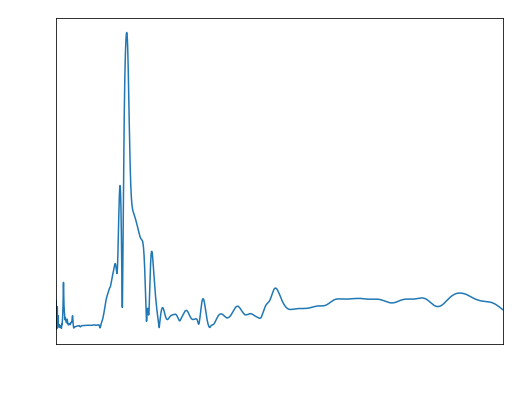

In [3]:
figsize(8,6)
def butterworth_lowpass(sig, cutoff, fs = 10000):
    sos = signal.butter(8, cutoff, 'lowpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2')

transf = transf_Alb
freqs = freqs_Alb

w2 = logspace(log10(freqs[1]),log10(freqs[-1+int(len(freqs)/2)]),100000)
T = transf(w2)

T_flt = butterworth_lowpass(absolute(T),100,fs=10000)

window = signal.hamming(int(700))
T_flt2 = signal.convolve(T,window, mode='same')/sum(window)

# plot(w2,absolute(T))
# plot(w2,absolute(T_flt2))


f = scipy.interpolate.interp1d(w2,T_flt2, kind='linear')

freq_lin = linspace(w2[0],w2[-1],99999)
transf_flt = np.zeros(shape(freqs),dtype=np.complex64)
transf_flt[1:100000] = f(freq_lin)
transf_flt[100000:] = np.flip(transf_flt[:100000])
plot(freqs[:int(len(freqs)/2)],absolute(transf_flt[:int(len(freqs)/2)]))
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
ylabel('Attenuation',size=20,color='white')
# title('Transfer Function',size=20,color='black')
xlim(0,400)
new_transf = scipy.interpolate.interp1d(freqs,transf_flt, kind='linear')
# savefig('Vector Function',transparent=True)

10.0


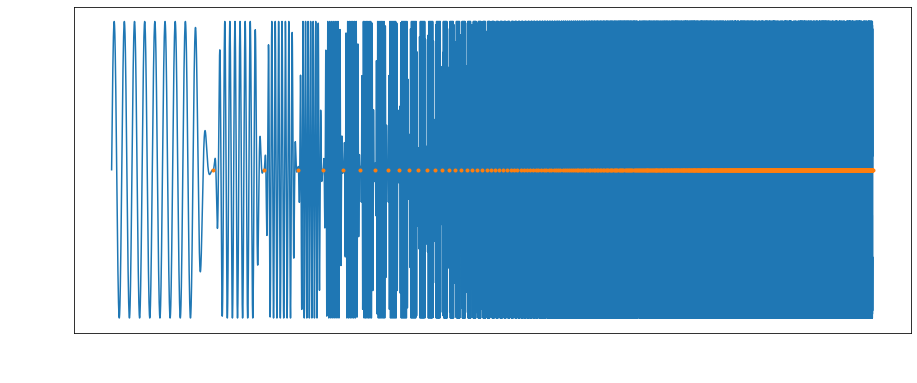

In [185]:
chirp,t_vec,loc,chirp_freqs,harmonic_chirp = chirp_wave(harmonic_freq=[10],res=0.1,View=True,
                                                        final_freq=100,harmonic_type='square', 
                                                        period=10, fs = 1000,start=0,
                                                        chirp_type = 'exponential')  

In [186]:
# sf.write('256_hz.wav', chirp, 44100, 'PCM_24')

(515, 519)

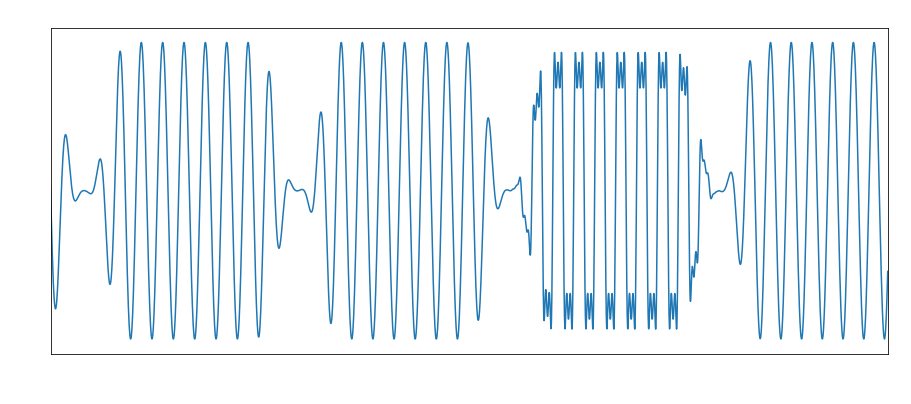

In [187]:
# chirp = chirp + np.random.random(len(chirp))
harmonic_chirp = harmonic_chirp*1e-7
plot(t_vec,harmonic_chirp)
tick_params(labelsize=12,colors='white')
xlabel('Time (secs)',size=20,color='white')
title('Chirp Waveform',size=20,color='white')
xlim(515,519)

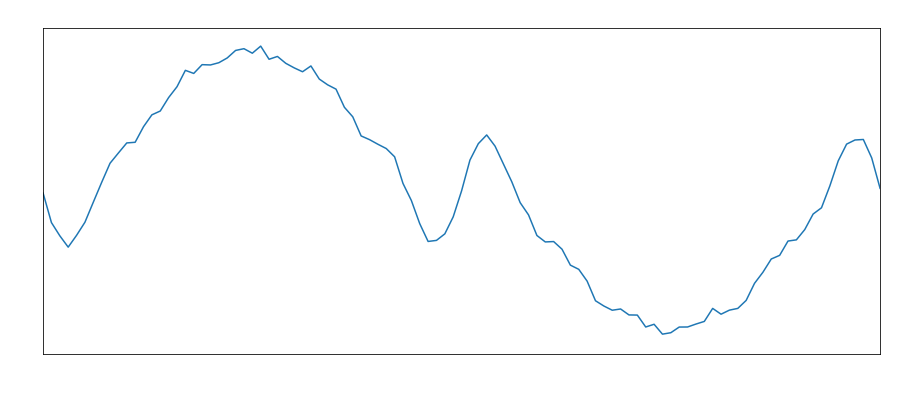

In [188]:
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver
t = linspace(0,int(t_vec[-1]),int(t_vec[-1])*1000)
geo = sin(10*2*pi*t) + 0.1*np.random.random(len(t))
mag = 1e-7
freqs = fft.fftfreq(len(geo),1/1000)
tip = geo*1e-7
for i in arange(5):
    harmonic = i*2 +3
    freq = 10*harmonic
    amp = 1/harmonic
    tip = tip + mag*amp*sin(freq*2*pi*t + harmonic*pi)
# plot(t,geo)
plot(t,tip)
tick_params(labelsize=12,colors='white')
xlabel('Time (secs)',size=20,color='white')
title('Tip waveform',size=20,color='white')
xlim(0,0.1)
vector_transf = fft.fft(geo)/fft.fft(tip)


In [189]:
print(chirp_freqs[-1])

100.0


In [326]:
prev = 0
# start = time.time()
harmonics = 20
fft_wave = fft.fft(chirp)
fftfreq = fft.fftfreq(10000,1/1000)
C = np.zeros((10000,harmonics),dtype='complex128')
C_1 = np.zeros(10000,dtype='complex128')
# print(freqs)
# print(len(fftfreq),len(chirp_freqs))

for w,point,i in zip(chirp_freqs,loc,arange(len(chirp_freqs))):
    if i == 0:
        continue
#     print(w,end='\r')
    input_wave = chirp[prev:point]
    output_wave = harmonic_chirp[prev:point]
    t_split = t_vec[prev:point]
    C_1[i] = coef(w,input_wave,output_wave,t_split,3)
    for j in arange(harmonics):
        print(i,end='\r')
        C[i,j] = coef(w,input_wave,output_wave,t_split,(j+1))
#         C[-(i),j] = conj(C[i,j])
    break
    prev = point
C[int(len(C[:,0])/2):,:] = flip(conj(C[1:int(len(C[:,0])/2)+1]),axis=0)
# print(C[10,1])
# print(C[-10,1])
# for j in arange(harmonics):
#     C[i+1:,j] = average(C[:i,j])*np.random.random(len(C[i+1:,j]))                 
#     print(average((C[:i,j])))
# C[int(len(C)/2):,:] = np.flip(C[1:int(len(C)/2),:],axis=0)

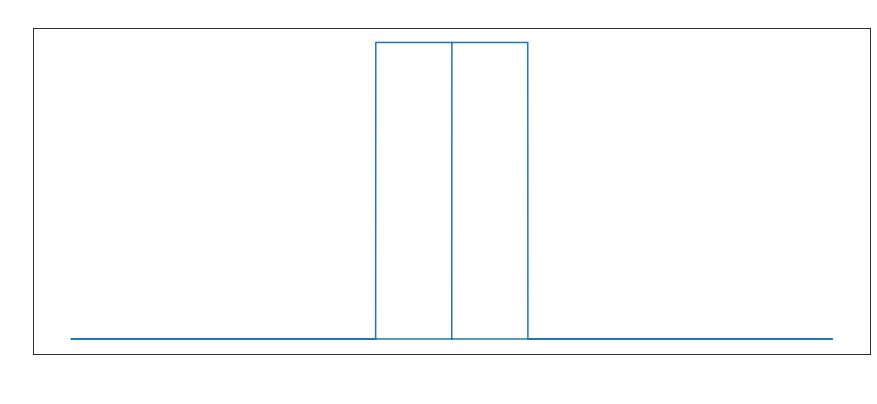

In [299]:
figsize(15,6)
interp_freq = fft.fftfreq(10000,1/1000)
# C[2500:7500,0]=0 + 0*1j
plot(interp_freq,(C[:,0]),label='1st Harmonic')
# plot(interp_freq,absolute(new_transf(interp_freq)),label='1st Harmonic')
# plot(interp_freq,absolute(C_1),label='Principal Transfer')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Coefficient Calculations',size=20,color='white')
# xlim(0,400)

C1 = scipy.interpolate.interp1d(interp_freq,C[:,0], kind='linear',fill_value='extrapolate')
C2 = scipy.interpolate.interp1d(interp_freq,C[:,1], kind='linear',fill_value='extrapolate')
C3 = scipy.interpolate.interp1d(interp_freq,C[:,2], kind='linear',fill_value='extrapolate')
C4 = scipy.interpolate.interp1d(interp_freq,C[:,3], kind='linear',fill_value='extrapolate')
C5 = scipy.interpolate.interp1d(interp_freq,C[:,4], kind='linear',fill_value='extrapolate')
C6 = scipy.interpolate.interp1d(interp_freq,C[:,5], kind='linear',fill_value='extrapolate')
C7 = scipy.interpolate.interp1d(interp_freq,C[:,6], kind='linear',fill_value='extrapolate')
C8 = scipy.interpolate.interp1d(interp_freq,C[:,7], kind='linear',fill_value='extrapolate')
C9 = scipy.interpolate.interp1d(interp_freq,C[:,8], kind='linear',fill_value='extrapolate')
C10 = scipy.interpolate.interp1d(interp_freq,C[:,9], kind='linear',fill_value='extrapolate')
C11 = scipy.interpolate.interp1d(interp_freq,C[:,10], kind='linear',fill_value='extrapolate')
C12 = scipy.interpolate.interp1d(interp_freq,C[:,11], kind='linear',fill_value='extrapolate')
C13 = scipy.interpolate.interp1d(interp_freq,C[:,12], kind='linear',fill_value='extrapolate')
C14 = scipy.interpolate.interp1d(interp_freq,C[:,13], kind='linear',fill_value='extrapolate')
C15 = scipy.interpolate.interp1d(interp_freq,C[:,14], kind='linear',fill_value='extrapolate')
C16 = scipy.interpolate.interp1d(interp_freq,C[:,15], kind='linear',fill_value='extrapolate')
C17 = scipy.interpolate.interp1d(interp_freq,C[:,16], kind='linear',fill_value='extrapolate')
C18 = scipy.interpolate.interp1d(interp_freq,C[:,17], kind='linear',fill_value='extrapolate')
C19 = scipy.interpolate.interp1d(interp_freq,C[:,18], kind='linear',fill_value='extrapolate')
C20 = scipy.interpolate.interp1d(interp_freq,C[:,19], kind='linear',fill_value='extrapolate')

In [416]:
vector_transf = fft.fft(tip)/fft.fft(geo)
freqs = fft.fftfreq(len(geo),1/1000)
vector_transf = scipy.interpolate.interp1d(freqs,vector_transf, kind='linear',fill_value='extrapolate')

t = linspace(0,100,100000)
test_wave = kaiser(len(t),100)*sin(10*2*pi*t) #+ 0.1*np.random.random(len(t))
# mag = new_transf(50)
mag = 1e-7
freqs = fft.fftfreq(len(t),1/1000)
# test_tip = create_drive(test_wave,1/1000,new_transf,freqs)
test_tip = 1e-7*test_wave
for i in arange(2):
    harmonic = i*2 +3
    freq = 10*harmonic
    amp = 1/harmonic
    test_tip = test_tip + mag*amp*sin(freq*2*pi*t + harmonic*pi)
G_amp = scipy.interpolate.interp1d(freqs,absolute(fft.fft(test_wave)), kind='linear',fill_value='extrapolate')
G_phase = scipy.interpolate.interp1d(freqs,0*angle(fft.fft(test_wave)), kind='linear',fill_value='extrapolate')
omega = fft.fftfreq(len(test_wave),1/1000)
matrix_transf = (C1(omega)*G_amp(omega)*exp(1j*G_phase(omega)) + C2(omega/2)*G_amp(omega/2)*exp(1j*G_phase(omega/2))) #+ C3(omega/3)*G(omega/5) +
#                  C4(omega/4)*G(omega/4) + C5(omega/5)*G(omega/5) + C6(omega/6)*G(omega/6) +
#                  C7(omega/7)*G(omega/7) + C8(omega/8)*G(omega/8) + C9(omega/9)*G(omega/9)) 

vector_approx = fft.ifft(vector_transf(omega)*fft.fft(test_wave))
matrix_approx = fft.ifft(matrix_transf)

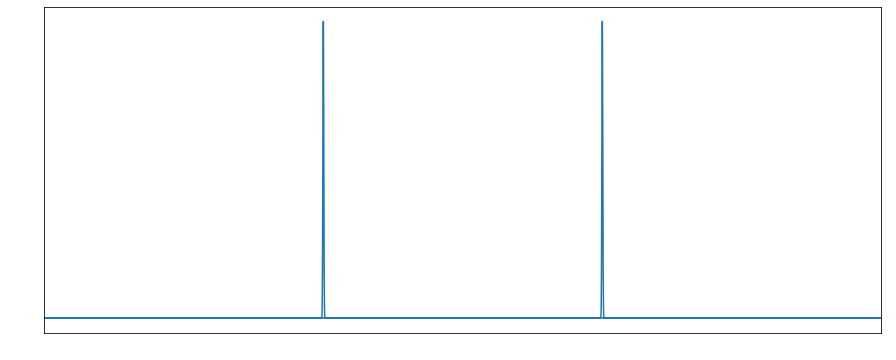

In [417]:
plot(freqs,G_amp(freqs))
xlim(-30,30)
tick_params(labelsize=12,colors='white')

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


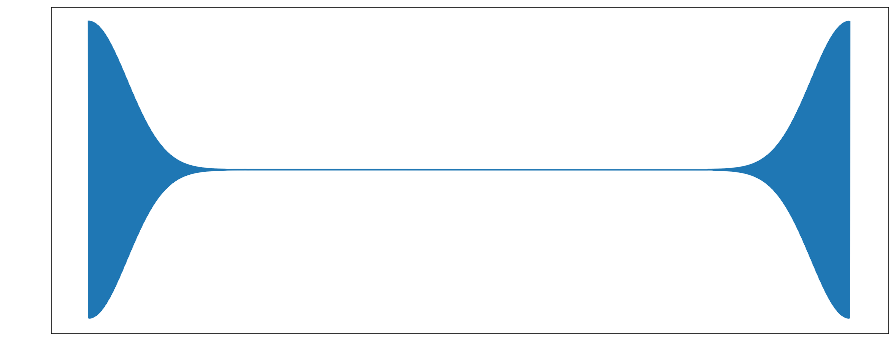

In [418]:
# plot(t,fft.ifft(C1(omega)*G(omega)))
print(angle(G_amp(omega)))
print(angle(G_amp(omega/2)))
plot(t,fft.ifft(G_amp(omega)*exp(1j*G_phase(omega))))
tick_params(labelsize=12,colors='white')
# xlabel('Frequency (Hz)',size=20,color='white')
# title('Coefficient Calculations',size=20,color='white')

(-1.913769824065393e-12+1.5348569686521415e-12j)


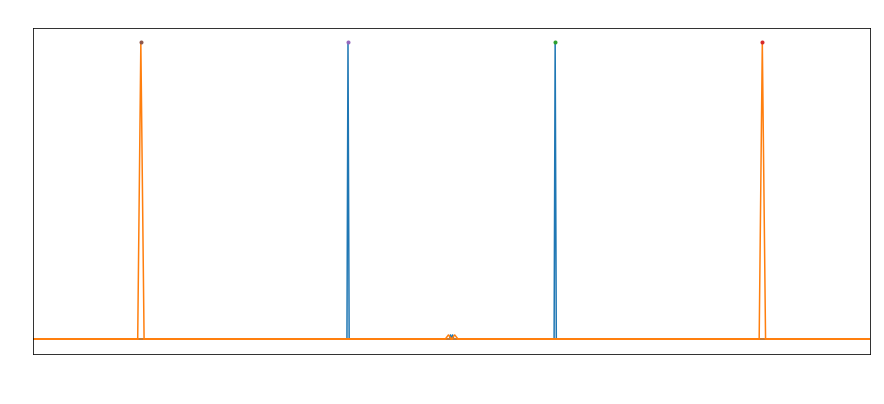

In [419]:
# plot(omega,(G(omega)*C1(omega) + G(omega/3)*(C3(omega/3))))
plot(omega,absolute(C3(omega)))
plot(omega,absolute(C3(omega/3)))
plot(omega[990],absolute(C3(omega[990])),'.')
plot(omega[2970],absolute(C3(omega[2970]/3)),'.')
plot(omega[-990],absolute(C3(omega[-990])),'.')
plot(omega[-2970],absolute(C3(omega[-2970]/3)),'.')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Coefficient Calculations',size=20,color='white')
# for i,w in enumerate(omega):
#     C3(w) = conj(C3(omega)[1,end:-1:2])
xlim(-40,40)
print(C3(10))
# print(C3(-10),C3(10))
# print(C1(-10),C1(10))

(-40, 40)

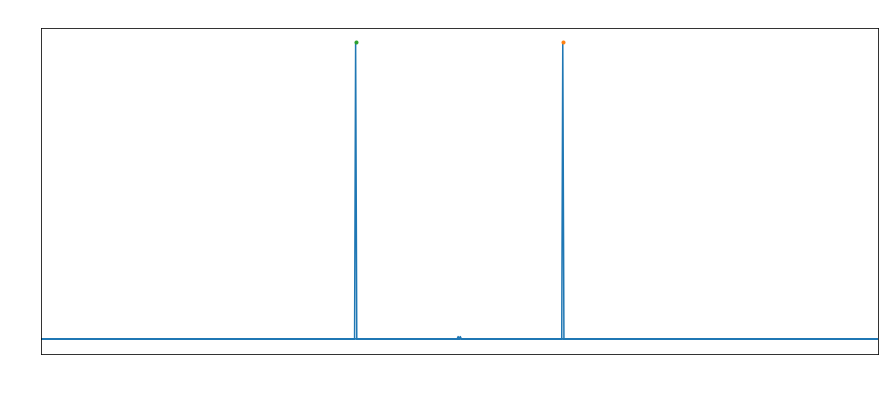

In [420]:

plot(omega,absolute(C5(omega)))

plot(omega[990],absolute(C5(omega[990])),'.')
plot(omega[-990],absolute(C5(omega[-990])),'.')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Coefficient Calculations',size=20,color='white')

xlim(-40,40)


(196.58768059102343-6255.52142663962j)


(-40, 40)

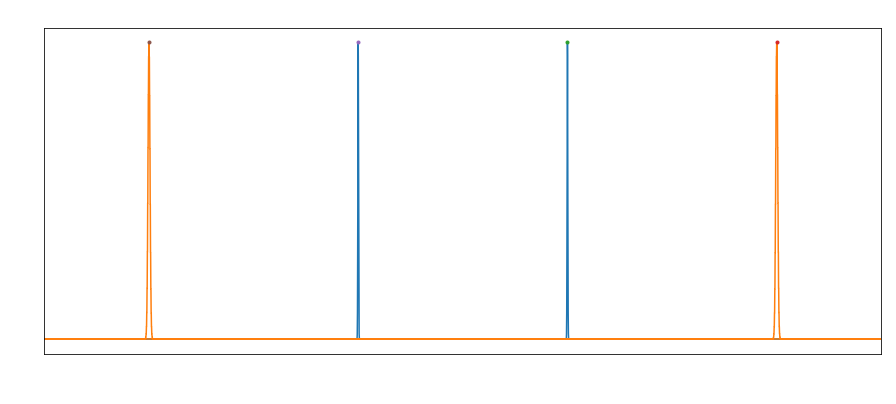

In [421]:
plot(omega,absolute(G(omega)))
plot(omega,absolute(G(omega/3)))
plot(omega[1000],absolute(G(omega[1000])),'.')
plot(omega[3000],absolute(G(omega[3000]/3)),'.')
plot(omega[-1000],absolute(G(omega[-1000])),'.')
plot(omega[-3000],absolute(G(omega[-3000]/3)),'.')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Signal',size=20,color='white')
print(G(10))
xlim(-40,40)

(9.2251070833325e-09+1.2273362111603696e-08j) (9.2251070833325e-09+1.2273362111603696e-08j)


(0, 40)

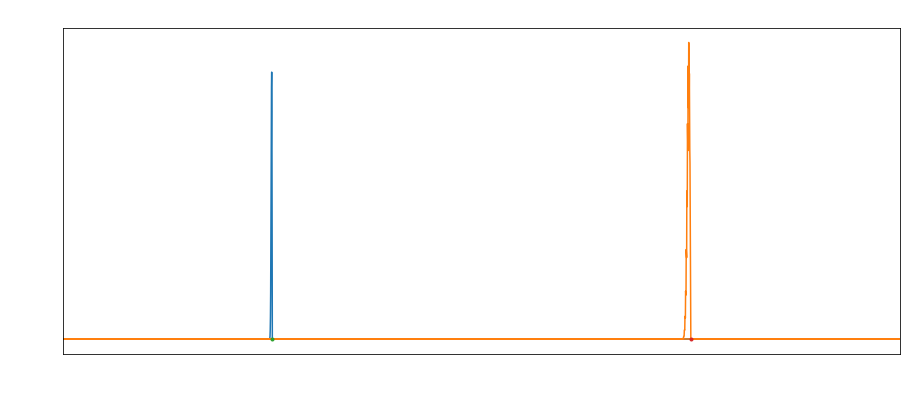

In [422]:
undivided = G(omega)*C3(omega)
divided = G(omega/3)*C3(omega/3)
plot(omega,absolute(G(omega)*C3(omega)))
plot(omega,absolute(G(omega/3)*C3(omega/3)))
plot(omega[1000],undivided[1000],'.')
plot(omega[3000],divided[3000],'.')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Estimation',size=20,color='white')
print(undivided[1000],divided[3000])
xlim(0,40)

Text(0.5, 1.0, 'Estimation calculations')

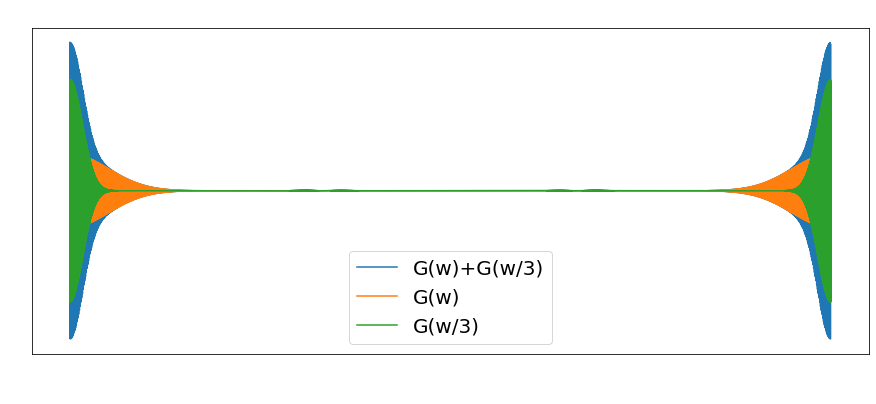

In [423]:
undivided = fft.ifft((G_amp(omega)*exp(1j*G_phase(omega))))
# print(G(omega[2]),G(omega[2]/3),G(omega[2])+G(omega[2]/3))
divided = fft.ifft(G_amp(omega/3)*exp(1j*G_phase(omega/3)))
summed = fft.ifft(G_amp(omega)*exp(1j*G_phase(omega))+G_amp(omega/3)*exp(1j*G_phase(omega/3)))
x = G(omega)
# print(x[3000])
# print(x[-3000])
plot(t,summed,label='G(w)+G(w/3)')
plot(t,undivided,label='G(w)')
# plot(fft.ifft(G(omega)))
# plot((G(omega/3)))
plot(t,divided,label='G(w/3)')
# print(undivided[2],divided[2])
tick_params(labelsize=12,colors='white')
legend(fontsize=20)
xlabel('Time (secs)',size=20,color='white')
title('Estimation calculations',size=20,color='white')
# xlim(0,10000)

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


33333 100000


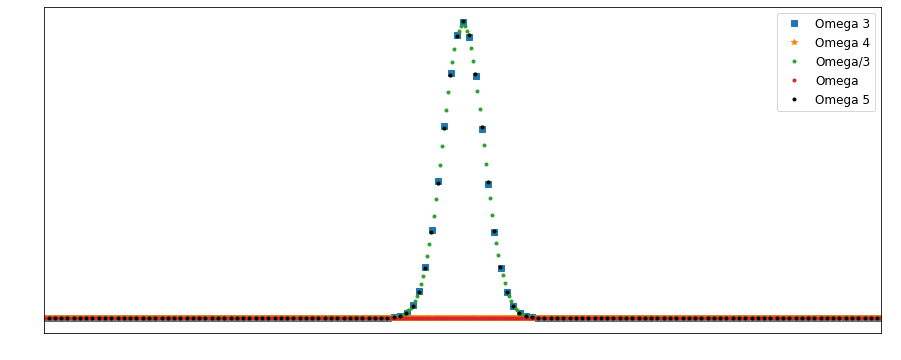

In [452]:
omega3 = linspace(-500/3,500/3,len(omega)/3)
omega4 = linspace(-500/3,500/3,len(omega))
plot(3*omega3,(G_amp(omega3)),'s',alpha=1,label='Omega 3')
plot(omega4,(G_amp(omega4)),'*',alpha=1,label='Omega 4')
plot(omega,G_amp(omega/3),'.',alpha=1,label='Omega/3')
plot(omega,(G_amp(omega)),'.',alpha=1,label='Omega')
plot(omega*3,G_amp(omega),'k.',alpha=1,label='Omega 5')
print(len(omega3),len(omega/3))
legend(fontsize=12)
xlim(28,32)
tick_params(labelsize=12,colors='white')

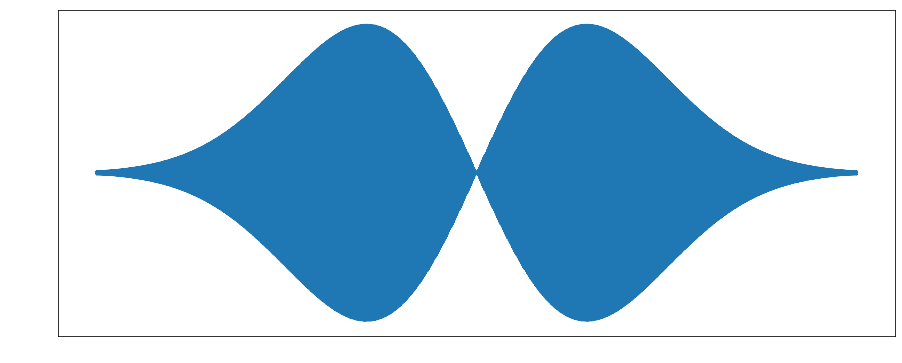

In [430]:
plot(t,fft.ifft(G(omega3)))
tick_params(labelsize=12,colors='white')

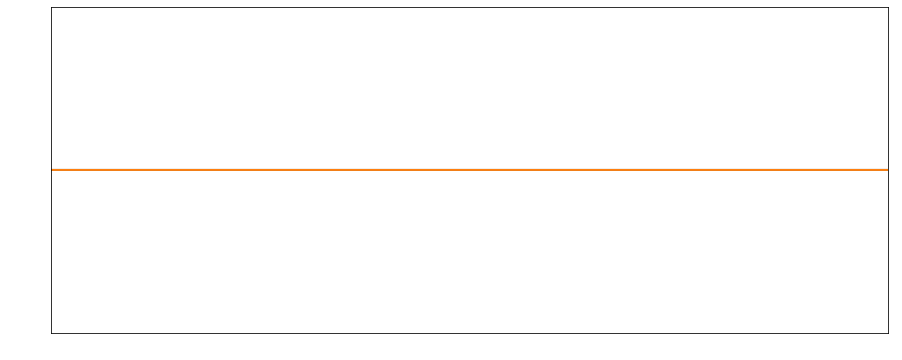

In [389]:
plot(omega,(G_phase(omega)))
plot(omega,(G_phase(omega/3)))
xlim(0,50)
tick_params(labelsize=12,colors='white')

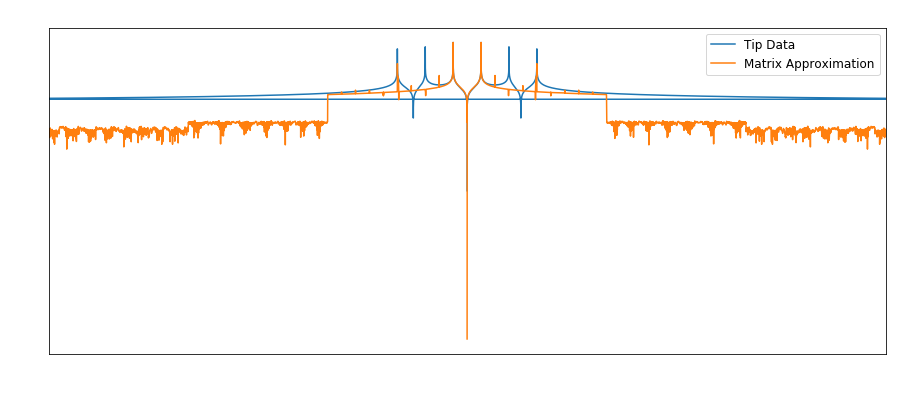

In [207]:
# semilogy(omega,absolute(vector_transf(omega)*fft.fft(test_wave)),label='Vector Approximation')
# semilogy(omega,absolute(fft.fft(test_wave)))

semilogy(omega,absolute(fft.fft(test_tip)),label='Tip Data')
semilogy(omega,absolute(matrix_transf),label='Matrix Approximation')
tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Tip Approximation Comparisons',size=20,color='white')
xlim(-300,300)
# ylim(1e-12,1e-1)
legend(fontsize=12)

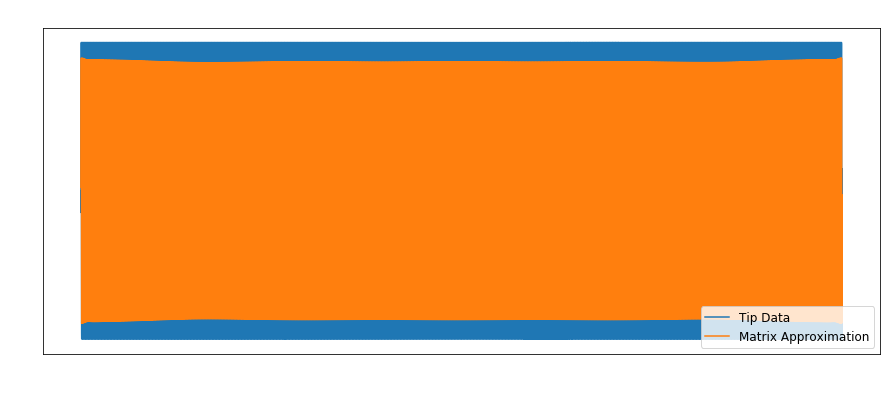

In [204]:

plot(t,(test_tip),label='Tip Data')
# plot(t,(vector_approx),label='Vector Approximation')
plot(t,(matrix_approx),label='Matrix Approximation')

tick_params(labelsize=12,colors='white')
xlabel('Time (secs)',size=20,color='white')
title('Tip Approximation Comparisons',size=20,color='white')
# xlim(40,40.1)
# ylim(-2e-8,2e-8)
legend(fontsize=12)

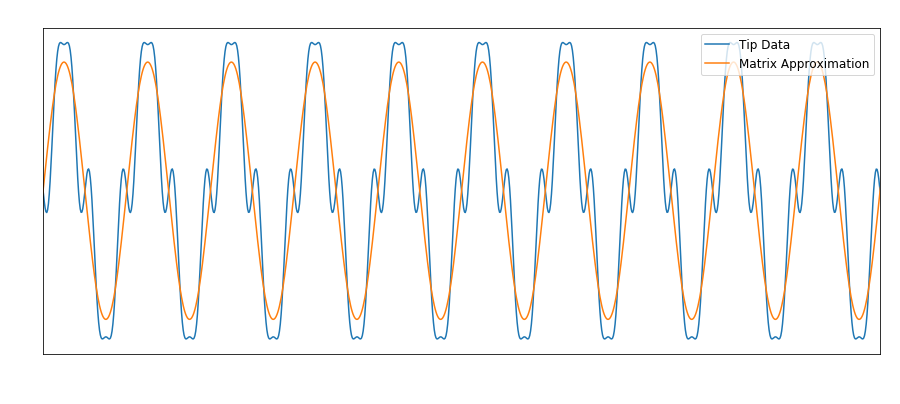

In [206]:
plot(t,(test_tip),label='Tip Data')
plot(t,(matrix_approx),label='Matrix Approximation')
# plot(t,(test_tip-matrix_approx),label='Matrix Cancellation')
# plot(t,(test_tip-vector_approx),label='Vector Cancellation')


tick_params(labelsize=12,colors='white')
xlabel('Time (secs)',size=20,color='white')
title('Tip Approximation Comparisons',size=20,color='white')
xlim(40,41)
legend(fontsize=12)
# ylim(-2e-8,2e-8)

In [40]:
x = linspace(0.1,9.9,99)
print(sum(8/x))

414.1902014111696


-199.99999999999997


(0, 50)

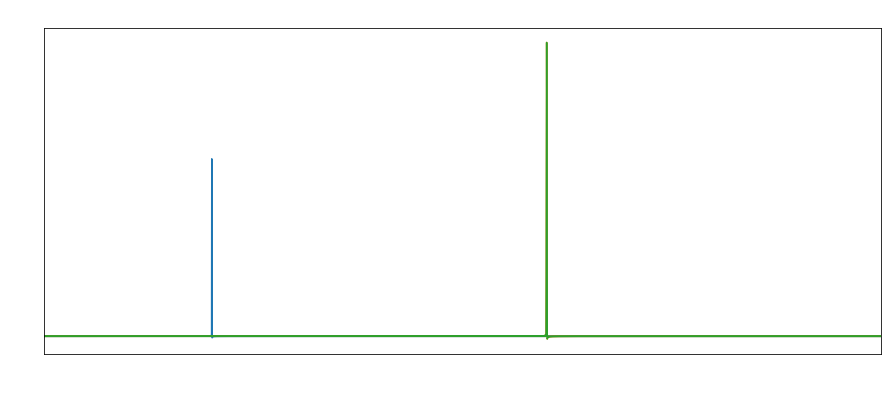

In [287]:
print(omega[50000]/3)
omega = fft.fftfreq(len(omega),1/1200)
freq_third = fft.fftfreq(len(omega),1/400)
plot(omega,G(omega))
plot(omega,G(omega/3))
plot(omega,G(freq_third))

tick_params(labelsize=12,colors='white')
xlabel('Frequency (Hz)',size=20,color='white')
title('Interpolation Comparisons',size=20,color='white')
xlim(0,50)

Text(0.5, 1.0, 'Interpolation Comparisons')

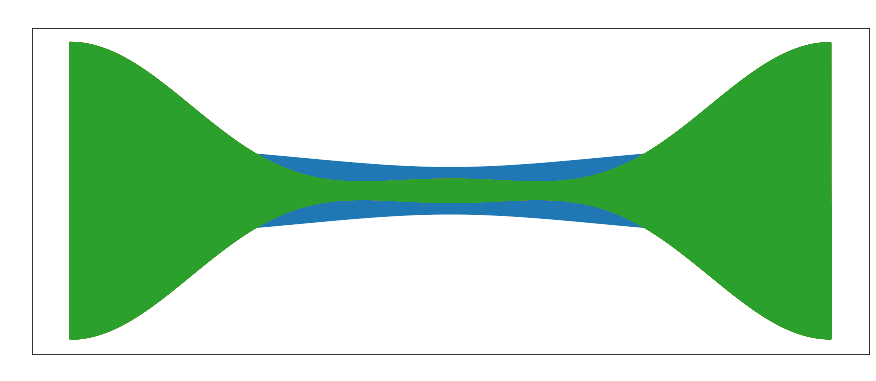

In [289]:
# omega = fft.fftfreq(len(omega),1/1200)
# freq_third = fft.fftfreq(len(omega),1/400)
# plot(fft.ifft(G(omega)))
# plot(fft.ifft(G(omega/3)))
# plot(fft.ifft(G(freq_third)))
# tick_params(labelsize=12,colors='white')
# # xlabel('Frequency (Hz)',size=20,color='white')
# title('Interpolation Comparisons',size=20,color='white')
# # xlim(0,50)

[-0.02222195+0.00000000e+00j -0.02222195-6.75455879e-07j
 -0.02222195-1.35101511e-06j ...  1.70751349+1.95969094e-03j
  1.7072875 +1.30646775e-03j  1.70715195+6.53235994e-04j]
[-0.02222195-0.00000000e+00j -0.02222195-6.75455879e-07j
 -0.02222195-1.35101511e-06j ...  1.70751349+1.95969094e-03j
  1.7072875 +1.30646775e-03j  1.70715195+6.53235994e-04j]
(2.514428099747131-0.06350183409913976j)
(2.514428099747131+0.06350183409913976j)


(0, 1000)

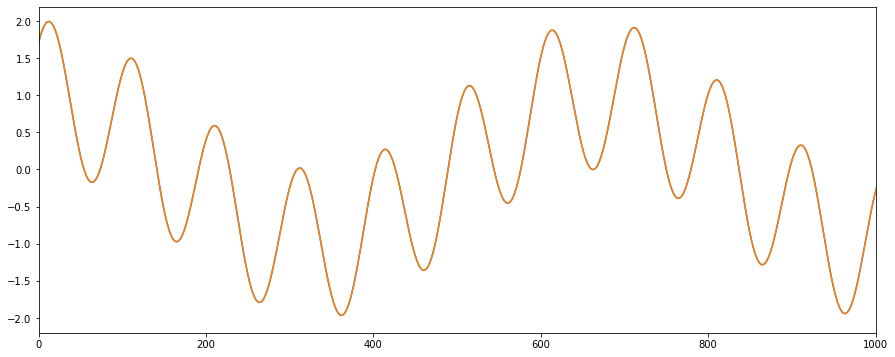

In [121]:
t= linspace(0,10,100000)
x = sin(100*2*pi*t + 0.25*pi) + sin(15*2*pi*t + 0.5*pi)
ffx = fft.fft(x)
plot(fft.ifft(ffx))
print(ffx[int(len(x)/2):])
ffx[int(len(x)/2):] = np.flip(np.conj(ffx[1:int(len(x)/2)+1]))
print(ffx[int(len(x)/2):])
plot(fft.ifft(ffx))
# plot(x)
freq = fft.fftfreq(len(x),1/1000)
print(ffx[100])
print(ffx[-100])
x_conj = sin(100*2*pi*t -0.25*pi)
# plot(ffx)
# plot(t,x)
# plot(t,x_conj)
# plot(t,x+x_conj)
xlim(0,1000)